# Import

In [1]:
!git init
!git pull https://github.com/terka2610/alz_det_ML.git

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 18120, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 18120 (delta 38), reused 20 (delta 20), pack-reused 18063 (from 1)
Receiving objects: 100% (18120/18120), 11.18 GiB | 34.72 MiB/s, done.
Resolving deltas: 100% (103/103), done.
From https://github.com/terka2610/alz_det_ML
 * branch              HEAD       -> FETCH_HEAD
Updating files: 100% (17306/17306), done.


In [1]:
!pip install PyWavelets
!pip install mne


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install torchviz
!pip install pyprep

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import numpy as np
import pandas as pd
import json
import os
import mne
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import time # To measure time


import matplotlib.pyplot as plt



In [2]:
def read_json_dicts (file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data_dict = json.load(f)
    return pd.DataFrame(data_dict)

def collect_eeg_data(folder_path):
    data = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(".set"):
            file_path = os.path.join(folder_path, filename)
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            data[filename] = raw.get_data()

    return data

# Preprocessing

## Model 2

# Models

## Model 2: charya et al., 2025

In [3]:


class ConvNeXt1DBlock(nn.Module):
    def __init__(self, dim, drop_p=0.):
        super().__init__()
        # Depthwise convolution (applied independently to each channel)
        self.dwconv = nn.Conv1d(dim, dim, kernel_size=7, padding=3, groups=dim)
        self.norm = nn.LayerNorm(dim, eps=1e-6) # LayerNorm applied on the channel dimension
        # Pointwise convolutions (expand and contract channels)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # Equivalent to 1x1 Conv for channel expansion
        self.act = nn.LeakyReLU(negative_slope=0.01)  # Change GELU to LeakyReLU
        self.pwconv2 = nn.Linear(4 * dim, dim) # Equivalent to 1x1 Conv for channel contraction
        self.drop_p = drop_p
        if self.drop_p > 0.0:
            self.dropout = nn.Dropout(drop_p)

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 1)  # (batch_size, timesteps, channels)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        x = x.permute(0, 2, 1)  # (batch_size, channels, timesteps)
        if self.drop_p > 0.0:
            x = self.dropout(x)
        x = input + x
        return x

class EEGConvNeXt_1D(nn.Module):
    def __init__(self, n_channels, n_timesteps, num_classes,
                 depths=[1, 1, 2, 1], dims=[96, 192, 384, 768], dropout_rate=0.5):
        super().__init__()

        self.n_timesteps = n_timesteps
        stem_kernel_size = 4
        stem_stride = 4
        self.stem = nn.Sequential(
            nn.Conv1d(n_channels, dims[0], kernel_size=stem_kernel_size, stride=stem_stride),
            nn.BatchNorm1d(dims[0]),  # Added BatchNorm after the first convolution
            nn.LeakyReLU(negative_slope=0.01),  # Added LeakyReLU after stem
        )
        current_timesteps = (n_timesteps - stem_kernel_size) // stem_stride + 1

        self.stages = nn.ModuleList()
        for i in range(4):  # 4 stages
            if i > 0:
                downsample_layer = nn.Sequential(
                    nn.BatchNorm1d(dims[i-1]),  # Added BatchNorm
                    nn.Conv1d(dims[i-1], dims[i], kernel_size=2, stride=2),
                    nn.LeakyReLU(negative_slope=0.01),  # LeakyReLU for better gradient flow
                )
                self.stages.append(downsample_layer)
                current_timesteps = (current_timesteps - 2) // 2 + 1

            stage_blocks = nn.Sequential(
                *[ConvNeXt1DBlock(dim=dims[i], drop_p=dropout_rate) for _ in range(depths[i])]
            )
            self.stages.append(stage_blocks)

        self.norm_out = nn.LayerNorm(dims[-1], eps=1e-6)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.head = nn.Linear(dims[-1], num_classes)

    def forward(self, x):
        x = self.stem(x)
        for stage_module in self.stages:
            x = stage_module(x)
        x = x.permute(0, 2, 1)
        x = self.norm_out(x)
        x = x.permute(0, 2, 1)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.head(x)
        return x


# Training

In [4]:
# --- Modified Generic Training Function with Validation ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """
    Generic function to train and validate a PyTorch model.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader or None): DataLoader for the validation data. If None, validation is skipped.
        criterion (nn.Module): The loss function (e.g., nn.CrossEntropyLoss).
        optimizer (Optimizer): The optimizer (e.g., optim.Adam).
        num_epochs (int): Number of epochs to train for.
        device (torch.device): The device to train on (CPU or CUDA).

    Returns:
        None: Prints training and validation progress information directly.
    """
    model.to(device) # Move model to the designated device
    total_train_steps = len(train_loader)
    if val_loader:
        total_val_steps = len(val_loader)
    start_time = time.time()

    print(f"\n--- Training {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        # --- Training Phase ---
        model.train() # Set the model to training mode
        epoch_train_loss = 0.0
        train_correct_predictions = 0
        train_total_samples = 0

        for i, (inputs, labels) in enumerate(train_loader):
            # Move data to the designated device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            # Accumulate training statistics
            epoch_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total_samples += labels.size(0)
            train_correct_predictions += (predicted == labels).sum().item()



        # Calculate average training loss and accuracy for the epoch
        avg_epoch_train_loss = epoch_train_loss / total_train_steps
        epoch_train_accuracy = 100 * train_correct_predictions / train_total_samples

        # --- Validation Phase ---
        if val_loader is not None:
            model.eval() # Set the model to evaluation mode
            epoch_val_loss = 0.0
            val_correct_predictions = 0
            val_total_samples = 0

            with torch.no_grad(): # Disable gradient calculations during validation
                for j, (val_inputs, val_labels) in enumerate(val_loader):
                    # Move data to the designated device
                    val_inputs = val_inputs.to(device)
                    val_labels = val_labels.to(device)

                    # Forward pass
                    val_outputs = model(val_inputs)
                    val_loss_batch = criterion(val_outputs, val_labels)

                    # Accumulate validation statistics
                    epoch_val_loss += val_loss_batch.item()

                    _, val_predicted = torch.max(val_outputs.data, 1)
                    # if j == 0:
                      # print(val_predicted)
                      # print(val_outputs)
                    val_total_samples += val_labels.size(0)
                    val_correct_predictions += (val_predicted == val_labels).sum().item()

            # Calculate average validation loss and accuracy for the epoch
            avg_epoch_val_loss = epoch_val_loss / total_val_steps
            epoch_val_accuracy = 100 * val_correct_predictions / val_total_samples

            # Print combined epoch results
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, '
                  f'Val Loss: {avg_epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%')
        else:
            # Print only training results if no validation loader is provided
            print(f'Epoch [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%')

        # Note: model is already set back to train() mode at the start of the next epoch loop iteration

    end_time = time.time()
    print(f"Finished Training {model.__class__.__name__}. Total time: {end_time - start_time:.2f} seconds")
    # --- Consider saving the best model based on validation performance ---
    # (Logic for tracking best val_accuracy/lowest val_loss and saving model state_dict would go here)

# Running

## Parameters

In [5]:
n_samples = 100   # Number of samples (example)
n_channels = 19  # Number of EEG channels (example)
n_timesteps = 1425 # Number of time points (example, may need adjustment for models like ConvNeXt)
num_classes = 3   # Number of classes
batch_size = 16
learning_rate = 0.01
num_epochs = 100    # Number of epochs (example, usually needs more)

## Import the data

In [6]:
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Ignore RuntimeWarning
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Enable CUDA
mne.utils.set_config('MNE_USE_CUDA', 'true')
mne.cuda.init_cuda(verbose=False)  # Set to True for debugging

In [7]:
folder_path_test = './test'             # Located in same directory as script
label_path = "Labels_epochs.json"

def collect_eeg_data_and_labels(folder_path, label_json):
    # 1) Load label map from JSON
    with open(label_json, 'r') as f:
        label_map = json.load(f)

    data = {}
    y = {}

    # 2) Walk through .set files
    for filename in os.listdir(folder_path):
        if not filename.endswith(".set"):
            continue

        sub_id = os.path.splitext(filename)[0][0:7]    # e.g. "sub-077"
        label = label_map.get(sub_id)
        # print(sub_id)
        if label is None:
            # no label available
            continue

        # 3) Read EEG and store
        raw = mne.io.read_raw_eeglab(os.path.join(folder_path, filename), preload=True)
        data[filename] = raw.get_data()
        y[filename]    = label

    return data, y

# Load everything
data_original_test, y_test_aligned = collect_eeg_data_and_labels(folder_path_test, label_path)
print(f"Loaded {len(data_original_test)} total entries with labels")



y_test_aligned = [y_test_aligned[key] for key in data_original_test.keys()]
y_test_aligned = np.array([y_test_aligned])

X_test_aligned = [data_original_test[key] for key in data_original_test.keys()]
X_test_aligned = np.array(X_test_aligned)




Loaded 898 total entries with labels


In [8]:
print("\n--- Test Data ---")
print(f"Test samples: {np.shape(X_test_aligned)[0]}")
print(f"Test labels: {np.size(y_test_aligned)}")
print(f"Unique test labels:: {np.unique(y_test_aligned)}")


--- Test Data ---
Test samples: 898
Test labels: 898
Unique test labels:: ['A' 'C' 'F']


In [9]:
folder_path_train = './train'             # Located in same directory as script
label_path = "Labels_epochs.json"

def collect_eeg_data_and_labels(folder_path, label_json):
    # 1) Load label map from JSON
    with open(label_json, 'r') as f:
        label_map = json.load(f)

    data = {}
    y = {}

    # 2) Walk through .set files
    for filename in os.listdir(folder_path):
        if not filename.endswith(".set"):
            continue

        sub_id = os.path.splitext(filename)[0][0:7]    # e.g. "sub-077"
        label = label_map.get(sub_id)
        # print(sub_id)
        if label is None:
            # no label available
            continue

        # 3) Read EEG and store
        raw = mne.io.read_raw_eeglab(os.path.join(folder_path, filename), preload=True)
        data[filename] = raw.get_data()
        y[filename]    = label

    return data, y

# Load everything
data_original_train, y_train_aligned = collect_eeg_data_and_labels(folder_path_train, label_path)
print(f"Loaded {len(data_original_train)} total entries with labels")



y_train_aligned = [y_train_aligned[key] for key in data_original_train.keys()]
y_train_aligned = np.array([y_train_aligned])

X_train_aligned = [data_original_train[key] for key in data_original_train.keys()]
X_train_aligned = np.array(X_train_aligned)


print("\n--- train Data ---")
print(f"train samples: {np.size(X_train_aligned)}")
print(f"train labels: {np.size(y_train_aligned)}")
print(f"Unique train labels: {np.unique(y_train_aligned)}")

Loaded 10644 total entries with labels

--- train Data ---
train samples: 288186300
train labels: 10644
Unique train labels: ['A' 'C' 'F']


In [10]:
print(data_original_test["sub-071_eeg_chunk_3.set"].shape)

(19, 1425)


In [11]:
folder_path_validate = './validate'             # Located in same directory as script
label_path = "Labels_epochs.json"

def collect_eeg_data_and_labels(folder_path, label_json):
    # 1) Load label map from JSON
    with open(label_json, 'r') as f:
        label_map = json.load(f)

    data = {}
    y = {}

    # 2) Walk through .set files
    for filename in os.listdir(folder_path):
        if not filename.endswith(".set"):
            continue

        sub_id = os.path.splitext(filename)[0][0:7]    # e.g. "sub-077"
        label = label_map.get(sub_id)
        # print(sub_id)
        if label is None:
            # no label available
            continue

        # 3) Read EEG and store
        raw = mne.io.read_raw_eeglab(os.path.join(folder_path, filename), preload=True)
        data[filename] = raw.get_data()
        y[filename]    = label

    return data, y

# Load everything
data_original_val, y_val_aligned = collect_eeg_data_and_labels(folder_path_validate, label_path)
print(f"Loaded {len(data_original_val)} total entries with labels")



y_val_aligned = [y_val_aligned[key] for key in data_original_val.keys()]
y_val_aligned = np.array([y_val_aligned])

X_val_aligned = [data_original_val[key] for key in data_original_val.keys()]
X_val_aligned = np.array(X_val_aligned)


print("\n--- val Data ---")
print(f"val samples: {np.shape(X_val_aligned)[0]}")
print(f"val labels: {np.size(y_val_aligned)}")
print(f"Unique val labels: {np.unique(y_val_aligned)}")

Loaded 877 total entries with labels

--- val Data ---
val samples: 877
val labels: 877
Unique val labels: ['A' 'C' 'F']


In [12]:

def normalize_eeg_data(data):
    """
    Normalize EEG data such that each channel in each sample has zero mean and unit variance.

    Args:
    - data (numpy.ndarray): EEG data with shape (n_samples, n_channels, n_timesteps)

    Returns:
    - normalized_data (numpy.ndarray): Normalized EEG data
    """
    # Check the shape of the data
    assert len(data.shape) == 3, "Input data must have 3 dimensions (n_samples, n_channels, n_timesteps)"

    # Normalize along the time dimension (axis=2) for each channel and each sample
    mean = np.mean(data, axis=2, keepdims=True)  # Mean along time axis (for each channel, per sample)
    std = np.std(data, axis=2, keepdims=True)  # Standard deviation along time axis (for each channel, per sample)

    normalized_data = (data - mean) / std  # Normalize each channel across time

    return normalized_data

## Preprocessing

In [13]:

import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder

print("\n--- Converting Processed Data to PyTorch Tensors ---")


## normalize

X_val_norm = normalize_eeg_data(X_val_aligned)


X_train_norm = normalize_eeg_data(X_train_aligned)

X_test_norm = normalize_eeg_data(X_test_aligned)

# # --- Convert X data ---

if np.size(X_train_aligned) > 0:
    X_train_tensor = torch.from_numpy(X_train_norm).float()

if np.size(X_val_aligned) > 0:
    X_val_tensor = torch.from_numpy(X_val_norm).float()


if np.size(X_test_aligned) > 0:
    X_test_tensor = torch.from_numpy(X_test_norm).float()

# --- Convert Y labels (LabelEncoder for CrossEntropyLoss) ---
label_encoder = LabelEncoder()
y_train_flat = y_train_aligned.flatten()
y_val_flat   = y_val_aligned.flatten()
y_test_flat  = y_test_aligned.flatten()

all_labels = np.concatenate([
    y_train_flat,
    y_val_flat,
    y_test_flat
])
label_encoder.fit(all_labels)  # Fit on all available labels

num_classes_actual = len(label_encoder.classes_)
print(f"LabelEncoder classes found: {list(label_encoder.classes_)} -> mapped to indices 0-{num_classes_actual - 1}")

# Encode each label split
y_train_indices = label_encoder.transform(y_train_flat)
y_val_indices = label_encoder.transform(y_val_flat)
y_test_indices = label_encoder.transform(y_test_flat)

# Convert to LongTensor for CrossEntropyLoss
y_train_tensor = torch.tensor(y_train_indices, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_indices, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_indices, dtype=torch.long)

# --- Summary Output ---
print(f"Tensor shapes: X_train={X_train_tensor.shape}, y_train={y_train_tensor.shape} ({y_train_tensor.dtype})")
if X_val_tensor.numel() > 0:
    print(f"Tensor shapes: X_val={X_val_tensor.shape}, y_val={y_val_tensor.shape} ({y_val_tensor.dtype})")
if X_test_tensor.numel() > 0:
    print(f"Tensor shapes: X_test={X_test_tensor.shape}, y_test={y_test_tensor.shape} ({y_test_tensor.dtype})")





--- Converting Processed Data to PyTorch Tensors ---
LabelEncoder classes found: [np.str_('A'), np.str_('C'), np.str_('F')] -> mapped to indices 0-2
Tensor shapes: X_train=torch.Size([10644, 19, 1425]), y_train=torch.Size([10644]) (torch.int64)
Tensor shapes: X_val=torch.Size([877, 19, 1425]), y_val=torch.Size([877]) (torch.int64)
Tensor shapes: X_test=torch.Size([898, 19, 1425]), y_test=torch.Size([898]) (torch.int64)


In [14]:
X_test_aligned.shape

(898, 19, 1425)

In [15]:

print("\n--- Creating DataLoaders ---")

# --- Train Loader ---
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# --- Validation Loader ---
val_loader = None
if X_val_tensor.shape[0] > 0:
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

# --- Test Loader ---
test_loader = None
if X_test_tensor.shape[0] > 0:
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")



--- Creating DataLoaders ---
DataLoaders created.


In [16]:
# --- Step 5: Initialize and Train Models ---
print("\n--- Initializing and Training Models ---")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Get actual dimensions from data tensors
actual_n_samples, actual_n_channels, actual_n_timesteps = X_train_tensor.shape
print(X_train_tensor.shape)



--- Initializing and Training Models ---
Using device: cuda
torch.Size([10644, 19, 1425])


## Running Model 2

In [17]:
def initialize_weights(model):
    for name, param in model.named_parameters():
        if 'weight' in name:
            if isinstance(param, nn.Conv1d):
                # Apply He (Kaiming) initialization for convolutional layers
                init.kaiming_normal_(param, mode='fan_out', nonlinearity='relu')
            elif isinstance(param, nn.Linear):
                # Apply Xavier initialization for linear layers
                init.xavier_normal_(param)
        elif 'bias' in name:
            # Initialize biases to zero or a small positive value
            init.zeros_(param)  # or init.constant_(param, 0.1) for small positive bias


In [18]:
def init_weights(m):
    if isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)



In [19]:
model2 = EEGConvNeXt_1D(n_channels=actual_n_channels,
                                n_timesteps=actual_n_timesteps,
                                depths = [2, 2, 4, 2],  # Increase depth
                                dims = [128, 256, 512, 1024],  # Increase dimensions
                                num_classes=num_classes_actual).to(device)
print(model2.parameters)

model2.apply(init_weights)


<bound method Module.parameters of EEGConvNeXt_1D(
  (stem): Sequential(
    (0): Conv1d(19, 128, kernel_size=(4,), stride=(4,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): ConvNeXt1DBlock(
        (dwconv): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,), groups=128)
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (1): ConvNeXt1DBlock(
        (dwconv): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,), groups=128)
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (pwconv1): Linear(in_features=128, out_features=512, bias

EEGConvNeXt_1D(
  (stem): Sequential(
    (0): Conv1d(19, 128, kernel_size=(4,), stride=(4,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (stages): ModuleList(
    (0): Sequential(
      (0): ConvNeXt1DBlock(
        (dwconv): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,), groups=128)
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): LeakyReLU(negative_slope=0.01)
        (pwconv2): Linear(in_features=512, out_features=128, bias=True)
        (dropout): Dropout(p=0.5, inplace=False)
      )
      (1): ConvNeXt1DBlock(
        (dwconv): Conv1d(128, 128, kernel_size=(7,), stride=(1,), padding=(3,), groups=128)
        (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
        (pwconv1): Linear(in_features=128, out_features=512, bias=True)
        (act): LeakyReLU(neg

In [20]:
num_epochs = 10

In [21]:

# --- Train Model 2: EEGConvNeXt_1D ---
if len(train_loader) > 0:
    try:
        print("\nInitializing Model 2: EEGConvNeXt_1D...")
        model2 = EEGConvNeXt_1D(n_channels=actual_n_channels,
                                n_timesteps=actual_n_timesteps,
                                num_classes=num_classes_actual).to(device)
        # criterion2 = nn.CrossEntropyLoss()
        # Set class weights (adjust these based on your dataset)
        class_weights = torch.tensor([1.0, 1.0, 1.0]).cuda()  # Example of class weights for imbalanced data

        # Define criterion with class weights
        criterion2 = nn.CrossEntropyLoss(weight=class_weights)


        optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
        train_model(model2, train_loader, val_loader, criterion2, optimizer2, num_epochs, device)
        # Add evaluation calls here if needed
    except NameError:
        print("Error: EEGConvNeXt_1D or PermuteLayerNorm class not defined.")
    except Exception as e:
        print(f"An error occurred during Model 2 training: {e}")
else:
    print("Skipping Model 2 training: Train loader is empty.")



Initializing Model 2: EEGConvNeXt_1D...

--- Training EEGConvNeXt_1D ---
Epoch [1/10], Train Loss: 1.1803, Train Acc: 40.79%, Val Loss: 1.0969, Val Acc: 40.48%
Epoch [2/10], Train Loss: 1.0658, Train Acc: 41.33%, Val Loss: 1.2237, Val Acc: 24.29%
Epoch [3/10], Train Loss: 1.0576, Train Acc: 41.38%, Val Loss: 1.1267, Val Acc: 40.48%
Epoch [4/10], Train Loss: 1.0581, Train Acc: 40.91%, Val Loss: 1.2202, Val Acc: 40.48%
Epoch [5/10], Train Loss: 1.0578, Train Acc: 41.62%, Val Loss: 1.2572, Val Acc: 40.48%
Epoch [6/10], Train Loss: 1.0566, Train Acc: 40.33%, Val Loss: 1.1874, Val Acc: 24.29%
Epoch [7/10], Train Loss: 1.0558, Train Acc: 41.75%, Val Loss: 1.2122, Val Acc: 40.48%
Epoch [8/10], Train Loss: 1.0059, Train Acc: 49.29%, Val Loss: 1.5787, Val Acc: 35.01%
Epoch [9/10], Train Loss: 0.8781, Train Acc: 59.78%, Val Loss: 1.5113, Val Acc: 35.23%
Epoch [10/10], Train Loss: 0.8211, Train Acc: 62.57%, Val Loss: 1.8892, Val Acc: 29.99%
Finished Training EEGConvNeXt_1D. Total time: 71.14 sec

In [22]:

from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

def evaluate_and_compare_models(model, name, data_loader, device, num_classes):
    """
    Evaluate multiple trained models on the same dataset and plot ROC curves.

    Args:
        models (list): List of trained PyTorch models.
        model_names (list): List of model names for labeling.
        data_loader (DataLoader): DataLoader for validation or test set.
        device (torch.device): Device for model execution.
        num_classes (int): Total number of output classes.

    Returns:
        reports (dict): A dictionary of classification report DataFrames per model.
    """
    reports = {}
    plt.figure(figsize=(8, 6))




    model.eval()
    y_true, y_pred, y_probs = [], [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_probs.extend(probs)
            y_true.extend(y_batch.numpy())
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())

    # Print Accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc*100:.2f}%")

    # Print classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()
    display(report_df[["precision", "recall", "f1-score", "support"]])
    reports[name] = report_df

    # Compute ROC Curve (Micro-average for multiclass)
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    y_probs = np.array(y_probs)

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    # ROC Plot settings
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.title("Micro-Averaged ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return reports



=== model 2 ===
Accuracy: 34.08%


,precision,recall,f1-score,support
0,0.500000,0.141732,0.220859,381.000000
1,0.318987,0.965517,0.479543,261.000000
2,0.000000,0.000000,0.000000,256.000000
accuracy,0.340757,0.340757,0.340757,0.340757
macro avg,0.272996,0.369083,0.233467,898.000000
weighted avg,0.304850,0.340757,0.233082,898.000000


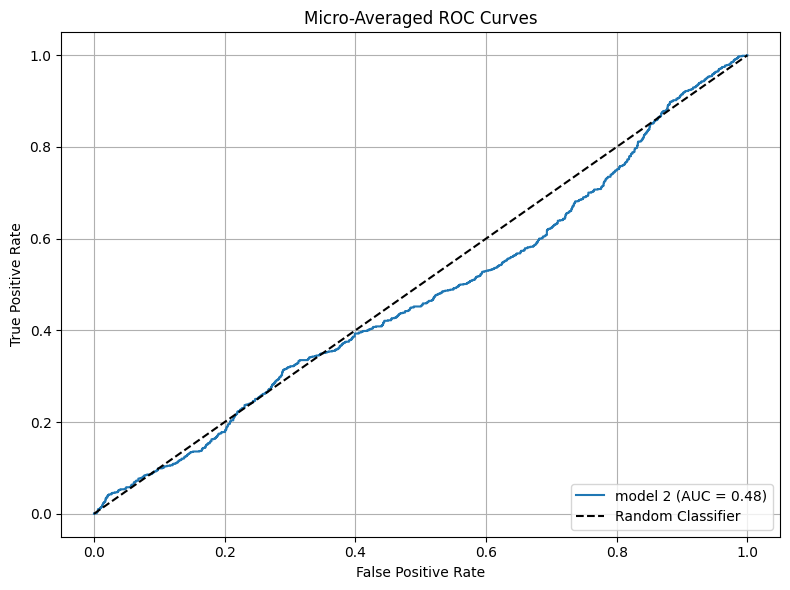

In [23]:
data_loader_to_use =  test_loader
if data_loader_to_use is None:
    raise ValueError("No data available for evaluation.")

all_reports = evaluate_and_compare_models(
    model=model2,
    name="model 2",
    data_loader=data_loader_to_use,
    device=device,
    num_classes=3
)


In [24]:
import optuna


In [25]:
def objective(trial):
    # ─── Hyperparameter suggestions ───
    lr           = trial.suggest_loguniform("learning_rate",   1e-5, 1e-2)
    weight_decay = trial.suggest_loguniform("weight_decay",   1e-6, 1e-2)
    dropout      = trial.suggest_float("dropout_rate",        0.2, 0.7)
    base_dim     = trial.suggest_categorical("base_dim",   [64, 96, 128])
    n_blocks     = trial.suggest_int("n_blocks",             1, 3)
    batch_size   = trial.suggest_categorical("batch_size", [8, 16, 32])

    # ─── Build model with sampled capacity + dropout ───
    model = EEGConvNeXt_1D(
        n_channels=actual_n_channels,
        n_timesteps=actual_n_timesteps,
        num_classes=num_classes_actual,
        depths=[n_blocks, n_blocks, n_blocks*2, n_blocks],
        dims=[base_dim, base_dim*2, base_dim*4, base_dim*8],
        dropout_rate=dropout
    ).to(device)

    model.apply(init_weights)


    # ─── Create loaders with sampled batch size ───
    train_loader = DataLoader(
        TensorDataset(X_train_tensor, y_train_tensor),
        batch_size=batch_size, shuffle=True
    )
    val_loader = DataLoader(
        TensorDataset(X_val_tensor, y_val_tensor),
        batch_size=batch_size, shuffle=False
    )

    # ─── Optimizer + weight decay ───
    optimizer = optim.Adam(
        model.parameters(),
        lr=lr,
        weight_decay=weight_decay
    )
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    # ─── Quick training ───
    train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs=20, device=device)

    # ─── Validation accuracy ───
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for Xv, yv in val_loader:
            Xv, yv = Xv.to(device), yv.to(device)
            preds = model(Xv).argmax(dim=1)
            correct += (preds == yv).sum().item()
            total   += yv.size(0)
    return correct / total


In [26]:
# Optionally use a pruner to stop bad trials early:
pruner = optuna.pruners.MedianPruner()

study = optuna.create_study(
    direction="maximize",
    study_name="eeg_hpo",
    pruner=pruner
)

study.optimize(objective, n_trials=30, timeout=9600)  # e.g. 30 trials or 1h max

print(f"Best Val Acc: {study.best_value:.4f}")
print("Best hyperparams:")
for key, val in study.best_params.items():
    print(f"  {key}: {val}")


[I 2025-05-07 01:46:58,789] A new study created in memory with name: eeg_hpo
/tmp/ipykernel_5640/3435734996.py:3: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr           = trial.suggest_loguniform("learning_rate",   1e-5, 1e-2)
/tmp/ipykernel_5640/3435734996.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay",   1e-6, 1e-2)



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.8256, Train Acc: 66.64%, Val Loss: 2.9097, Val Acc: 42.99%
Epoch [2/20], Train Loss: 0.5246, Train Acc: 76.13%, Val Loss: 6.7100, Val Acc: 39.79%
Epoch [3/20], Train Loss: 0.4306, Train Acc: 80.09%, Val Loss: 4.4622, Val Acc: 37.63%
Epoch [4/20], Train Loss: 0.3818, Train Acc: 82.16%, Val Loss: 4.5801, Val Acc: 40.14%
Epoch [5/20], Train Loss: 0.3370, Train Acc: 84.44%, Val Loss: 6.6194, Val Acc: 32.04%
Epoch [6/20], Train Loss: 0.3087, Train Acc: 86.48%, Val Loss: 5.7362, Val Acc: 35.01%
Epoch [7/20], Train Loss: 0.2655, Train Acc: 88.95%, Val Loss: 5.2980, Val Acc: 39.68%
Epoch [8/20], Train Loss: 0.2363, Train Acc: 90.63%, Val Loss: 4.5063, Val Acc: 36.83%
Epoch [9/20], Train Loss: 0.1814, Train Acc: 93.31%, Val Loss: 6.7575, Val Acc: 38.77%
Epoch [10/20], Train Loss: 0.1417, Train Acc: 94.89%, Val Loss: 6.5243, Val Acc: 35.80%
Epoch [11/20], Train Loss: 0.1247, Train Acc: 96.02%, Val Loss: 13.4338, Val Acc: 28.73%
Epoch [

[I 2025-05-07 01:49:33,356] Trial 0 finished with value: 0.35347776510832385 and parameters: {'learning_rate': 0.0002012263266299448, 'weight_decay': 1.2404139999790797e-06, 'dropout_rate': 0.21398473384511313, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 16}. Best is trial 0 with value: 0.35347776510832385.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.9953, Train Acc: 53.08%, Val Loss: 2.3312, Val Acc: 33.30%
Epoch [2/20], Train Loss: 0.7481, Train Acc: 66.15%, Val Loss: 3.6741, Val Acc: 34.66%
Epoch [3/20], Train Loss: 0.6009, Train Acc: 72.73%, Val Loss: 4.3085, Val Acc: 33.64%
Epoch [4/20], Train Loss: 0.5386, Train Acc: 75.65%, Val Loss: 3.7449, Val Acc: 39.45%
Epoch [5/20], Train Loss: 0.5015, Train Acc: 76.56%, Val Loss: 3.7527, Val Acc: 38.65%
Epoch [6/20], Train Loss: 0.4660, Train Acc: 78.53%, Val Loss: 5.0588, Val Acc: 38.88%
Epoch [7/20], Train Loss: 0.4437, Train Acc: 79.69%, Val Loss: 4.3349, Val Acc: 41.39%
Epoch [8/20], Train Loss: 0.4300, Train Acc: 80.34%, Val Loss: 5.4191, Val Acc: 34.78%
Epoch [9/20], Train Loss: 0.3924, Train Acc: 81.25%, Val Loss: 5.7796, Val Acc: 35.58%
Epoch [10/20], Train Loss: 0.3783, Train Acc: 82.21%, Val Loss: 5.8315, Val Acc: 37.74%
Epoch [11/20], Train Loss: 0.3636, Train Acc: 82.55%, Val Loss: 5.6606, Val Acc: 40.25%
Epoch [1

[I 2025-05-07 01:56:16,059] Trial 1 finished with value: 0.35917901938426455 and parameters: {'learning_rate': 0.00011716874858621579, 'weight_decay': 5.202023439678176e-06, 'dropout_rate': 0.6205557921989057, 'base_dim': 96, 'n_blocks': 2, 'batch_size': 8}. Best is trial 1 with value: 0.35917901938426455.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.8276, Train Acc: 63.16%, Val Loss: 3.8545, Val Acc: 41.16%
Epoch [2/20], Train Loss: 0.5413, Train Acc: 75.54%, Val Loss: 5.5446, Val Acc: 38.77%
Epoch [3/20], Train Loss: 0.4600, Train Acc: 78.67%, Val Loss: 3.2214, Val Acc: 33.87%
Epoch [4/20], Train Loss: 0.4080, Train Acc: 80.91%, Val Loss: 3.4504, Val Acc: 37.17%
Epoch [5/20], Train Loss: 0.3664, Train Acc: 82.78%, Val Loss: 4.3718, Val Acc: 37.51%
Epoch [6/20], Train Loss: 0.3372, Train Acc: 84.22%, Val Loss: 5.3788, Val Acc: 31.24%
Epoch [7/20], Train Loss: 0.2943, Train Acc: 86.71%, Val Loss: 4.5609, Val Acc: 34.55%
Epoch [8/20], Train Loss: 0.2697, Train Acc: 88.64%, Val Loss: 3.7885, Val Acc: 37.86%
Epoch [9/20], Train Loss: 0.2185, Train Acc: 91.11%, Val Loss: 4.0623, Val Acc: 36.60%
Epoch [10/20], Train Loss: 0.1766, Train Acc: 93.32%, Val Loss: 4.7165, Val Acc: 36.94%
Epoch [11/20], Train Loss: 0.1422, Train Acc: 94.91%, Val Loss: 4.7098, Val Acc: 38.20%
Epoch [1

[I 2025-05-07 01:59:46,027] Trial 2 finished with value: 0.3933865450399088 and parameters: {'learning_rate': 0.00019450117968237345, 'weight_decay': 0.00031663302014960413, 'dropout_rate': 0.26712996197780897, 'base_dim': 96, 'n_blocks': 2, 'batch_size': 16}. Best is trial 2 with value: 0.3933865450399088.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.8463, Train Acc: 62.01%, Val Loss: 1.5620, Val Acc: 43.90%
Epoch [2/20], Train Loss: 0.6794, Train Acc: 69.36%, Val Loss: 1.8791, Val Acc: 38.43%
Epoch [3/20], Train Loss: 0.6402, Train Acc: 70.68%, Val Loss: 1.8964, Val Acc: 39.57%
Epoch [4/20], Train Loss: 0.6318, Train Acc: 70.43%, Val Loss: 2.2992, Val Acc: 36.72%
Epoch [5/20], Train Loss: 0.6343, Train Acc: 70.50%, Val Loss: 1.9845, Val Acc: 36.03%
Epoch [6/20], Train Loss: 0.6340, Train Acc: 70.78%, Val Loss: 2.8393, Val Acc: 28.39%
Epoch [7/20], Train Loss: 0.6436, Train Acc: 71.15%, Val Loss: 2.0881, Val Acc: 34.09%
Epoch [8/20], Train Loss: 0.6489, Train Acc: 70.32%, Val Loss: 2.0664, Val Acc: 40.59%
Epoch [9/20], Train Loss: 0.6522, Train Acc: 70.15%, Val Loss: 2.2174, Val Acc: 38.31%
Epoch [10/20], Train Loss: 0.6655, Train Acc: 69.70%, Val Loss: 1.5277, Val Acc: 41.96%
Epoch [11/20], Train Loss: 0.6625, Train Acc: 69.23%, Val Loss: 2.3154, Val Acc: 28.96%
Epoch [1

[I 2025-05-07 02:04:11,654] Trial 3 finished with value: 0.2839224629418472 and parameters: {'learning_rate': 0.0005758178423490434, 'weight_decay': 0.004963251707140753, 'dropout_rate': 0.30314139084769925, 'base_dim': 64, 'n_blocks': 1, 'batch_size': 8}. Best is trial 2 with value: 0.3933865450399088.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1013, Train Acc: 40.92%, Val Loss: 1.5281, Val Acc: 24.29%
Epoch [2/20], Train Loss: 0.8647, Train Acc: 59.25%, Val Loss: 1.9210, Val Acc: 35.46%
Epoch [3/20], Train Loss: 0.6524, Train Acc: 71.42%, Val Loss: 2.0630, Val Acc: 35.80%
Epoch [4/20], Train Loss: 0.5465, Train Acc: 76.81%, Val Loss: 1.9265, Val Acc: 37.63%
Epoch [5/20], Train Loss: 0.4608, Train Acc: 81.50%, Val Loss: 2.1334, Val Acc: 33.98%
Epoch [6/20], Train Loss: 0.4165, Train Acc: 83.77%, Val Loss: 1.8932, Val Acc: 39.11%
Epoch [7/20], Train Loss: 0.3875, Train Acc: 85.04%, Val Loss: 1.7551, Val Acc: 37.63%
Epoch [8/20], Train Loss: 0.3636, Train Acc: 87.27%, Val Loss: 1.7715, Val Acc: 38.43%
Epoch [9/20], Train Loss: 0.3528, Train Acc: 88.32%, Val Loss: 1.6397, Val Acc: 42.08%
Epoch [10/20], Train Loss: 0.3543, Train Acc: 88.58%, Val Loss: 1.5916, Val Acc: 38.88%
Epoch [11/20], Train Loss: 0.3524, Train Acc: 89.68%, Val Loss: 1.5892, Val Acc: 36.60%
Epoch [1

[I 2025-05-07 02:10:54,166] Trial 4 finished with value: 0.3557582668187001 and parameters: {'learning_rate': 3.498681667330291e-05, 'weight_decay': 0.009469595367345407, 'dropout_rate': 0.688963205593684, 'base_dim': 64, 'n_blocks': 2, 'batch_size': 8}. Best is trial 2 with value: 0.3933865450399088.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1759, Train Acc: 40.43%, Val Loss: 1.1465, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0635, Train Acc: 40.44%, Val Loss: 1.2607, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0635, Train Acc: 41.49%, Val Loss: 1.2510, Val Acc: 24.29%
Epoch [4/20], Train Loss: 1.0614, Train Acc: 40.35%, Val Loss: 1.1666, Val Acc: 24.29%
Epoch [5/20], Train Loss: 1.0563, Train Acc: 41.22%, Val Loss: 1.1516, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0603, Train Acc: 40.81%, Val Loss: 1.2215, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0554, Train Acc: 40.88%, Val Loss: 1.1981, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0600, Train Acc: 41.16%, Val Loss: 1.2192, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0514, Train Acc: 40.91%, Val Loss: 1.2452, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0581, Train Acc: 41.01%, Val Loss: 1.2246, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0568, Train Acc: 40.87%, Val Loss: 1.0931, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 02:15:27,427] Trial 5 finished with value: 0.4047890535917902 and parameters: {'learning_rate': 0.00836174147858395, 'weight_decay': 1.8056443588778537e-05, 'dropout_rate': 0.5845118646576506, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.9557, Train Acc: 63.13%, Val Loss: 3.6956, Val Acc: 42.08%
Epoch [2/20], Train Loss: 0.5516, Train Acc: 74.96%, Val Loss: 2.8738, Val Acc: 31.36%
Epoch [3/20], Train Loss: 0.4646, Train Acc: 78.04%, Val Loss: 3.4531, Val Acc: 40.36%
Epoch [4/20], Train Loss: 0.4335, Train Acc: 79.43%, Val Loss: 2.8015, Val Acc: 39.91%
Epoch [5/20], Train Loss: 0.3879, Train Acc: 81.73%, Val Loss: 2.7977, Val Acc: 39.22%
Epoch [6/20], Train Loss: 0.3752, Train Acc: 81.82%, Val Loss: 3.7466, Val Acc: 36.26%
Epoch [7/20], Train Loss: 0.3460, Train Acc: 83.48%, Val Loss: 3.5052, Val Acc: 37.06%
Epoch [8/20], Train Loss: 0.3247, Train Acc: 84.88%, Val Loss: 3.8338, Val Acc: 38.65%
Epoch [9/20], Train Loss: 0.3111, Train Acc: 85.75%, Val Loss: 4.3976, Val Acc: 36.49%
Epoch [10/20], Train Loss: 0.2852, Train Acc: 87.23%, Val Loss: 4.1771, Val Acc: 36.72%
Epoch [11/20], Train Loss: 0.2668, Train Acc: 88.28%, Val Loss: 4.2608, Val Acc: 36.49%
Epoch [1

[I 2025-05-07 02:17:28,359] Trial 6 finished with value: 0.3694412770809578 and parameters: {'learning_rate': 0.0007625679308912389, 'weight_decay': 0.0002866080644924093, 'dropout_rate': 0.3711067985158759, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 32}. Best is trial 5 with value: 0.4047890535917902.


Epoch [20/20], Train Loss: 0.1493, Train Acc: 94.67%, Val Loss: 5.7928, Val Acc: 36.94%
Finished Training EEGConvNeXt_1D. Total time: 120.62 seconds

--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.9012, Train Acc: 59.83%, Val Loss: 2.8490, Val Acc: 38.54%
Epoch [2/20], Train Loss: 0.5739, Train Acc: 73.84%, Val Loss: 2.1786, Val Acc: 41.62%
Epoch [3/20], Train Loss: 0.5253, Train Acc: 75.70%, Val Loss: 2.0205, Val Acc: 40.59%
Epoch [4/20], Train Loss: 0.5005, Train Acc: 76.57%, Val Loss: 2.2246, Val Acc: 39.91%
Epoch [5/20], Train Loss: 0.4794, Train Acc: 77.72%, Val Loss: 2.8107, Val Acc: 34.21%
Epoch [6/20], Train Loss: 0.4627, Train Acc: 78.31%, Val Loss: 2.3940, Val Acc: 43.10%
Epoch [7/20], Train Loss: 0.4438, Train Acc: 79.15%, Val Loss: 2.6308, Val Acc: 36.37%
Epoch [8/20], Train Loss: 0.4359, Train Acc: 79.65%, Val Loss: 2.8212, Val Acc: 37.17%
Epoch [9/20], Train Loss: 0.4380, Train Acc: 79.47%, Val Loss: 2.7001, Val Acc: 39.57%
Epoch [10/20], Train Loss: 0.4408, 

[I 2025-05-07 02:21:58,935] Trial 7 finished with value: 0.3956670467502851 and parameters: {'learning_rate': 0.00040680169750350605, 'weight_decay': 0.0028354894431111893, 'dropout_rate': 0.6675460406266935, 'base_dim': 64, 'n_blocks': 3, 'batch_size': 16}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.9580, Train Acc: 61.68%, Val Loss: 6.1563, Val Acc: 27.37%
Epoch [2/20], Train Loss: 0.5110, Train Acc: 75.97%, Val Loss: 3.3020, Val Acc: 31.58%
Epoch [3/20], Train Loss: 0.4567, Train Acc: 78.31%, Val Loss: 3.7033, Val Acc: 36.94%
Epoch [4/20], Train Loss: 0.3967, Train Acc: 80.70%, Val Loss: 3.8346, Val Acc: 39.11%
Epoch [5/20], Train Loss: 0.3724, Train Acc: 82.04%, Val Loss: 4.7240, Val Acc: 36.26%
Epoch [6/20], Train Loss: 0.3432, Train Acc: 83.77%, Val Loss: 4.3971, Val Acc: 36.49%
Epoch [7/20], Train Loss: 0.3244, Train Acc: 84.55%, Val Loss: 4.7297, Val Acc: 34.32%
Epoch [8/20], Train Loss: 0.3040, Train Acc: 86.57%, Val Loss: 4.0124, Val Acc: 37.17%
Epoch [9/20], Train Loss: 0.2781, Train Acc: 87.65%, Val Loss: 4.2829, Val Acc: 36.49%
Epoch [10/20], Train Loss: 0.2537, Train Acc: 89.08%, Val Loss: 4.2999, Val Acc: 33.98%
Epoch [11/20], Train Loss: 0.2250, Train Acc: 90.91%, Val Loss: 4.7140, Val Acc: 37.29%
Epoch [1

[I 2025-05-07 02:23:59,528] Trial 8 finished with value: 0.3933865450399088 and parameters: {'learning_rate': 0.0005165076249896145, 'weight_decay': 0.00028963058456652396, 'dropout_rate': 0.5644871254947746, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 32}. Best is trial 5 with value: 0.4047890535917902.


Epoch [20/20], Train Loss: 0.0873, Train Acc: 97.08%, Val Loss: 7.1404, Val Acc: 39.34%
Finished Training EEGConvNeXt_1D. Total time: 120.29 seconds

--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1106, Train Acc: 40.76%, Val Loss: 1.0997, Val Acc: 39.11%
Epoch [2/20], Train Loss: 0.8642, Train Acc: 59.39%, Val Loss: 1.8572, Val Acc: 39.91%
Epoch [3/20], Train Loss: 0.6698, Train Acc: 70.06%, Val Loss: 2.2439, Val Acc: 37.86%
Epoch [4/20], Train Loss: 0.5562, Train Acc: 75.08%, Val Loss: 2.3928, Val Acc: 38.31%
Epoch [5/20], Train Loss: 0.4840, Train Acc: 78.34%, Val Loss: 2.3820, Val Acc: 40.02%
Epoch [6/20], Train Loss: 0.4228, Train Acc: 82.00%, Val Loss: 2.3049, Val Acc: 39.91%
Epoch [7/20], Train Loss: 0.3732, Train Acc: 84.49%, Val Loss: 2.1230, Val Acc: 39.00%
Epoch [8/20], Train Loss: 0.3435, Train Acc: 86.44%, Val Loss: 2.1499, Val Acc: 41.28%
Epoch [9/20], Train Loss: 0.3147, Train Acc: 88.25%, Val Loss: 2.2296, Val Acc: 37.86%
Epoch [10/20], Train Loss: 0.2883, 

[I 2025-05-07 02:32:36,929] Trial 9 finished with value: 0.35119726339794755 and parameters: {'learning_rate': 3.8918863322576624e-05, 'weight_decay': 0.0037113171852921436, 'dropout_rate': 0.6202491847828939, 'base_dim': 64, 'n_blocks': 3, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1850, Train Acc: 40.55%, Val Loss: 1.1920, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0592, Train Acc: 39.82%, Val Loss: 1.2137, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0528, Train Acc: 41.38%, Val Loss: 1.2037, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0540, Train Acc: 41.08%, Val Loss: 1.1340, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0525, Train Acc: 41.51%, Val Loss: 1.1925, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0528, Train Acc: 40.71%, Val Loss: 1.2848, Val Acc: 24.29%
Epoch [7/20], Train Loss: 1.0504, Train Acc: 41.58%, Val Loss: 1.1795, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0473, Train Acc: 40.32%, Val Loss: 1.2351, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0513, Train Acc: 41.67%, Val Loss: 1.1702, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0479, Train Acc: 41.53%, Val Loss: 1.1562, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0485, Train Acc: 41.17%, Val Loss: 1.1323, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 02:37:01,769] Trial 10 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.005771856383123271, 'weight_decay': 1.9424541207414068e-05, 'dropout_rate': 0.4857264672176199, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1327, Train Acc: 39.98%, Val Loss: 1.4655, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0496, Train Acc: 40.79%, Val Loss: 1.2141, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0461, Train Acc: 41.16%, Val Loss: 1.1452, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0460, Train Acc: 40.66%, Val Loss: 1.2067, Val Acc: 24.29%
Epoch [5/20], Train Loss: 1.0448, Train Acc: 41.48%, Val Loss: 1.1175, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0463, Train Acc: 41.42%, Val Loss: 1.2090, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0468, Train Acc: 42.00%, Val Loss: 1.2310, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0439, Train Acc: 40.81%, Val Loss: 1.2329, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0458, Train Acc: 41.34%, Val Loss: 1.2351, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0445, Train Acc: 41.18%, Val Loss: 1.2300, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0462, Train Acc: 41.54%, Val Loss: 1.2254, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 02:41:30,768] Trial 11 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.006499582399870366, 'weight_decay': 2.769646770168462e-05, 'dropout_rate': 0.5093571259741112, 'base_dim': 64, 'n_blocks': 3, 'batch_size': 16}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1624, Train Acc: 41.14%, Val Loss: 1.6240, Val Acc: 35.80%
Epoch [2/20], Train Loss: 0.9186, Train Acc: 56.92%, Val Loss: 2.2442, Val Acc: 30.67%
Epoch [3/20], Train Loss: 0.8447, Train Acc: 61.57%, Val Loss: 2.2775, Val Acc: 36.72%
Epoch [4/20], Train Loss: 0.7899, Train Acc: 64.52%, Val Loss: 3.0799, Val Acc: 35.58%
Epoch [5/20], Train Loss: 0.7631, Train Acc: 65.36%, Val Loss: 2.6051, Val Acc: 28.05%
Epoch [6/20], Train Loss: 0.7434, Train Acc: 66.38%, Val Loss: 2.9595, Val Acc: 35.01%
Epoch [7/20], Train Loss: 0.7311, Train Acc: 67.49%, Val Loss: 2.9307, Val Acc: 31.70%
Epoch [8/20], Train Loss: 0.7140, Train Acc: 68.00%, Val Loss: 2.9425, Val Acc: 32.04%
Epoch [9/20], Train Loss: 0.6858, Train Acc: 69.73%, Val Loss: 2.7269, Val Acc: 33.18%
Epoch [10/20], Train Loss: 0.6666, Train Acc: 70.58%, Val Loss: 3.7667, Val Acc: 30.90%
Epoch [11/20], Train Loss: 0.6084, Train Acc: 72.85%, Val Loss: 3.5099, Val Acc: 33.18%
Epoch [1

[I 2025-05-07 02:47:44,147] Trial 12 finished with value: 0.35689851767388825 and parameters: {'learning_rate': 0.0018416345993481713, 'weight_decay': 4.2902149686741474e-05, 'dropout_rate': 0.6898682175694308, 'base_dim': 128, 'n_blocks': 3, 'batch_size': 16}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.0040, Train Acc: 55.07%, Val Loss: 1.8551, Val Acc: 26.23%
Epoch [2/20], Train Loss: 0.7845, Train Acc: 63.12%, Val Loss: 2.2980, Val Acc: 35.80%
Epoch [3/20], Train Loss: 0.7608, Train Acc: 63.98%, Val Loss: 1.8996, Val Acc: 29.42%
Epoch [4/20], Train Loss: 0.7360, Train Acc: 65.58%, Val Loss: 2.1385, Val Acc: 31.47%
Epoch [5/20], Train Loss: 0.7115, Train Acc: 67.16%, Val Loss: 2.1192, Val Acc: 34.89%
Epoch [6/20], Train Loss: 0.6905, Train Acc: 68.97%, Val Loss: 2.2985, Val Acc: 30.22%
Epoch [7/20], Train Loss: 0.6494, Train Acc: 71.23%, Val Loss: 2.2590, Val Acc: 32.38%
Epoch [8/20], Train Loss: 0.5883, Train Acc: 73.88%, Val Loss: 2.9670, Val Acc: 39.34%
Epoch [9/20], Train Loss: 0.5523, Train Acc: 74.36%, Val Loss: 3.6541, Val Acc: 27.94%
Epoch [10/20], Train Loss: 0.5347, Train Acc: 75.32%, Val Loss: 2.6849, Val Acc: 34.78%
Epoch [11/20], Train Loss: 0.5224, Train Acc: 76.09%, Val Loss: 3.3567, Val Acc: 35.23%
Epoch [1

[I 2025-05-07 02:52:08,892] Trial 13 finished with value: 0.37856328392246297 and parameters: {'learning_rate': 0.002110057433318378, 'weight_decay': 0.001328695967351504, 'dropout_rate': 0.5826826195306846, 'base_dim': 64, 'n_blocks': 3, 'batch_size': 16}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.0673, Train Acc: 42.97%, Val Loss: 1.5182, Val Acc: 38.88%
Epoch [2/20], Train Loss: 0.9619, Train Acc: 52.86%, Val Loss: 1.7211, Val Acc: 37.06%
Epoch [3/20], Train Loss: 0.8237, Train Acc: 61.89%, Val Loss: 2.0979, Val Acc: 35.92%
Epoch [4/20], Train Loss: 0.7265, Train Acc: 67.43%, Val Loss: 2.8208, Val Acc: 29.76%
Epoch [5/20], Train Loss: 0.6784, Train Acc: 69.68%, Val Loss: 2.8007, Val Acc: 30.56%
Epoch [6/20], Train Loss: 0.6364, Train Acc: 71.51%, Val Loss: 3.4415, Val Acc: 28.51%
Epoch [7/20], Train Loss: 0.6046, Train Acc: 73.10%, Val Loss: 2.4925, Val Acc: 36.15%
Epoch [8/20], Train Loss: 0.5720, Train Acc: 75.20%, Val Loss: 2.7250, Val Acc: 34.55%
Epoch [9/20], Train Loss: 0.5527, Train Acc: 75.89%, Val Loss: 2.7206, Val Acc: 36.26%
Epoch [10/20], Train Loss: 0.5406, Train Acc: 76.24%, Val Loss: 2.6862, Val Acc: 38.20%
Epoch [11/20], Train Loss: 0.5163, Train Acc: 77.74%, Val Loss: 3.2074, Val Acc: 31.36%
Epoch [1

[I 2025-05-07 02:54:33,077] Trial 14 finished with value: 0.3261117445838084 and parameters: {'learning_rate': 1.3347235378213595e-05, 'weight_decay': 7.441857865967697e-06, 'dropout_rate': 0.44710618474792063, 'base_dim': 96, 'n_blocks': 2, 'batch_size': 32}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1305, Train Acc: 40.68%, Val Loss: 1.2707, Val Acc: 24.29%
Epoch [2/20], Train Loss: 1.0467, Train Acc: 41.32%, Val Loss: 1.4113, Val Acc: 40.48%
Epoch [3/20], Train Loss: 1.0453, Train Acc: 40.95%, Val Loss: 1.4053, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0446, Train Acc: 40.76%, Val Loss: 1.2270, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0440, Train Acc: 41.51%, Val Loss: 1.3157, Val Acc: 24.29%
Epoch [6/20], Train Loss: 1.0428, Train Acc: 41.78%, Val Loss: 1.3218, Val Acc: 24.29%
Epoch [7/20], Train Loss: 1.0439, Train Acc: 41.43%, Val Loss: 1.2207, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0440, Train Acc: 41.70%, Val Loss: 1.1838, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0437, Train Acc: 41.15%, Val Loss: 1.1201, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0428, Train Acc: 42.14%, Val Loss: 1.1822, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0432, Train Acc: 40.62%, Val Loss: 1.1933, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 03:01:26,053] Trial 15 finished with value: 0.4047890535917902 and parameters: {'learning_rate': 0.002002362131805346, 'weight_decay': 8.579921681313816e-05, 'dropout_rate': 0.6460676934367313, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1486, Train Acc: 39.80%, Val Loss: 1.2595, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0601, Train Acc: 41.32%, Val Loss: 1.2391, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0596, Train Acc: 41.29%, Val Loss: 1.1474, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0580, Train Acc: 40.85%, Val Loss: 1.1585, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0540, Train Acc: 40.41%, Val Loss: 1.1929, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0590, Train Acc: 40.71%, Val Loss: 1.1380, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0583, Train Acc: 41.63%, Val Loss: 1.0830, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0561, Train Acc: 41.40%, Val Loss: 1.2699, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0610, Train Acc: 39.94%, Val Loss: 1.2106, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0574, Train Acc: 40.87%, Val Loss: 1.2153, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0584, Train Acc: 41.69%, Val Loss: 1.3539, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 03:08:17,612] Trial 16 finished with value: 0.4047890535917902 and parameters: {'learning_rate': 0.008970059409010227, 'weight_decay': 9.481473469046507e-05, 'dropout_rate': 0.5383662572676507, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1932, Train Acc: 39.55%, Val Loss: 1.3852, Val Acc: 24.29%
Epoch [2/20], Train Loss: 1.0510, Train Acc: 41.69%, Val Loss: 1.2061, Val Acc: 40.48%
Epoch [3/20], Train Loss: 1.0492, Train Acc: 41.87%, Val Loss: 1.2713, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0471, Train Acc: 40.80%, Val Loss: 1.2270, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0456, Train Acc: 41.74%, Val Loss: 1.2379, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0448, Train Acc: 41.00%, Val Loss: 1.1480, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0456, Train Acc: 40.82%, Val Loss: 1.1442, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0447, Train Acc: 40.46%, Val Loss: 1.1724, Val Acc: 24.29%
Epoch [9/20], Train Loss: 1.0448, Train Acc: 41.80%, Val Loss: 1.1770, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0456, Train Acc: 41.01%, Val Loss: 1.1325, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0447, Train Acc: 41.04%, Val Loss: 1.1805, Val Acc: 24.29%
Epoch [1

[I 2025-05-07 03:15:06,208] Trial 17 finished with value: 0.4047890535917902 and parameters: {'learning_rate': 0.0023988052576423306, 'weight_decay': 5.845375592185409e-06, 'dropout_rate': 0.4335328736098069, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1472, Train Acc: 40.03%, Val Loss: 1.4048, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0571, Train Acc: 41.56%, Val Loss: 1.3479, Val Acc: 40.48%
Epoch [3/20], Train Loss: 1.0528, Train Acc: 41.41%, Val Loss: 1.2796, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0518, Train Acc: 41.33%, Val Loss: 1.2798, Val Acc: 24.29%
Epoch [5/20], Train Loss: 1.0513, Train Acc: 41.18%, Val Loss: 1.3136, Val Acc: 24.29%
Epoch [6/20], Train Loss: 1.0502, Train Acc: 40.64%, Val Loss: 1.1751, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0502, Train Acc: 41.60%, Val Loss: 1.2056, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0482, Train Acc: 41.38%, Val Loss: 1.1683, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0510, Train Acc: 40.67%, Val Loss: 1.1210, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0485, Train Acc: 41.61%, Val Loss: 1.2534, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0496, Train Acc: 41.15%, Val Loss: 1.1356, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 03:19:28,964] Trial 18 finished with value: 0.4047890535917902 and parameters: {'learning_rate': 0.0035079522850319325, 'weight_decay': 1.0595702347385217e-06, 'dropout_rate': 0.6149895592741483, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.0572, Train Acc: 53.46%, Val Loss: 2.3072, Val Acc: 28.51%
Epoch [2/20], Train Loss: 0.6828, Train Acc: 68.81%, Val Loss: 2.9452, Val Acc: 30.56%
Epoch [3/20], Train Loss: 0.5993, Train Acc: 72.91%, Val Loss: 2.6065, Val Acc: 32.61%
Epoch [4/20], Train Loss: 0.5505, Train Acc: 74.95%, Val Loss: 2.5320, Val Acc: 37.17%
Epoch [5/20], Train Loss: 0.5233, Train Acc: 75.82%, Val Loss: 4.3843, Val Acc: 31.70%
Epoch [6/20], Train Loss: 0.5209, Train Acc: 76.28%, Val Loss: 4.0337, Val Acc: 30.90%
Epoch [7/20], Train Loss: 0.4964, Train Acc: 76.69%, Val Loss: 3.1228, Val Acc: 39.79%
Epoch [8/20], Train Loss: 0.4725, Train Acc: 78.59%, Val Loss: 3.3792, Val Acc: 42.19%
Epoch [9/20], Train Loss: 0.4650, Train Acc: 78.80%, Val Loss: 3.9781, Val Acc: 39.45%
Epoch [10/20], Train Loss: 0.4407, Train Acc: 79.48%, Val Loss: 3.7179, Val Acc: 41.51%
Epoch [11/20], Train Loss: 0.4296, Train Acc: 80.64%, Val Loss: 3.7796, Val Acc: 35.69%
Epoch [1

[I 2025-05-07 03:23:54,140] Trial 19 finished with value: 0.3774230330672748 and parameters: {'learning_rate': 0.0010192288443977998, 'weight_decay': 0.0001005627238639806, 'dropout_rate': 0.39183959578894956, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1152, Train Acc: 41.25%, Val Loss: 1.2004, Val Acc: 24.29%
Epoch [2/20], Train Loss: 1.0483, Train Acc: 41.01%, Val Loss: 1.1634, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0482, Train Acc: 42.09%, Val Loss: 1.1802, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0474, Train Acc: 41.83%, Val Loss: 1.2174, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0501, Train Acc: 40.48%, Val Loss: 1.1842, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0490, Train Acc: 41.21%, Val Loss: 1.2225, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0496, Train Acc: 41.65%, Val Loss: 1.1313, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0484, Train Acc: 41.15%, Val Loss: 1.1326, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0501, Train Acc: 41.11%, Val Loss: 1.2037, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0483, Train Acc: 41.07%, Val Loss: 1.2169, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0505, Train Acc: 41.35%, Val Loss: 1.2350, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 03:30:45,887] Trial 20 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.004331078126634706, 'weight_decay': 0.0006160213193201132, 'dropout_rate': 0.6434146575170074, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1712, Train Acc: 40.60%, Val Loss: 1.1021, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0615, Train Acc: 41.85%, Val Loss: 1.4675, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0631, Train Acc: 41.49%, Val Loss: 1.1443, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0581, Train Acc: 41.04%, Val Loss: 1.1249, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0614, Train Acc: 40.76%, Val Loss: 1.1627, Val Acc: 24.29%
Epoch [6/20], Train Loss: 1.0558, Train Acc: 41.30%, Val Loss: 1.1940, Val Acc: 24.29%
Epoch [7/20], Train Loss: 1.0633, Train Acc: 40.45%, Val Loss: 1.2301, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0647, Train Acc: 40.70%, Val Loss: 1.2491, Val Acc: 24.29%
Epoch [9/20], Train Loss: 1.0578, Train Acc: 41.66%, Val Loss: 1.1302, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0655, Train Acc: 40.92%, Val Loss: 1.1134, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0593, Train Acc: 41.85%, Val Loss: 1.2713, Val Acc: 24.29%
Epoch [1

[I 2025-05-07 03:37:35,447] Trial 21 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.009697232486138992, 'weight_decay': 9.403368816765349e-05, 'dropout_rate': 0.5479005826754251, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1905, Train Acc: 40.04%, Val Loss: 1.1531, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0582, Train Acc: 40.97%, Val Loss: 1.1380, Val Acc: 40.48%
Epoch [3/20], Train Loss: 1.0603, Train Acc: 39.70%, Val Loss: 1.3681, Val Acc: 24.29%
Epoch [4/20], Train Loss: 1.0599, Train Acc: 40.69%, Val Loss: 1.1709, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0573, Train Acc: 41.33%, Val Loss: 1.1384, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0680, Train Acc: 40.57%, Val Loss: 1.1946, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0603, Train Acc: 41.12%, Val Loss: 1.1781, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0576, Train Acc: 41.23%, Val Loss: 1.2108, Val Acc: 24.29%
Epoch [9/20], Train Loss: 1.0584, Train Acc: 40.51%, Val Loss: 1.3162, Val Acc: 24.29%
Epoch [10/20], Train Loss: 1.0586, Train Acc: 40.37%, Val Loss: 1.2375, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0537, Train Acc: 41.07%, Val Loss: 1.1869, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 03:44:34,939] Trial 22 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.009697551648386314, 'weight_decay': 8.889802977975085e-05, 'dropout_rate': 0.5248457620646353, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1400, Train Acc: 41.60%, Val Loss: 1.7550, Val Acc: 34.44%
Epoch [2/20], Train Loss: 1.0283, Train Acc: 48.88%, Val Loss: 1.2832, Val Acc: 26.68%
Epoch [3/20], Train Loss: 0.9641, Train Acc: 56.02%, Val Loss: 1.9652, Val Acc: 36.15%
Epoch [4/20], Train Loss: 0.8330, Train Acc: 62.96%, Val Loss: 2.7469, Val Acc: 37.06%
Epoch [5/20], Train Loss: 0.7807, Train Acc: 64.60%, Val Loss: 2.7156, Val Acc: 35.58%
Epoch [6/20], Train Loss: 0.7406, Train Acc: 67.10%, Val Loss: 2.2645, Val Acc: 35.35%
Epoch [7/20], Train Loss: 0.7081, Train Acc: 68.76%, Val Loss: 2.6244, Val Acc: 35.01%
Epoch [8/20], Train Loss: 0.6546, Train Acc: 72.03%, Val Loss: 2.7151, Val Acc: 35.23%
Epoch [9/20], Train Loss: 0.5966, Train Acc: 74.20%, Val Loss: 3.5329, Val Acc: 40.14%
Epoch [10/20], Train Loss: 0.5280, Train Acc: 77.18%, Val Loss: 3.6672, Val Acc: 40.94%
Epoch [11/20], Train Loss: 0.4950, Train Acc: 78.34%, Val Loss: 6.4157, Val Acc: 37.29%
Epoch [1

[I 2025-05-07 03:51:37,311] Trial 23 finished with value: 0.3933865450399088 and parameters: {'learning_rate': 0.0015773004064479732, 'weight_decay': 1.384621276038966e-05, 'dropout_rate': 0.5890561809168028, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1707, Train Acc: 40.98%, Val Loss: 1.3346, Val Acc: 24.29%
Epoch [2/20], Train Loss: 1.0504, Train Acc: 40.54%, Val Loss: 1.3872, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0483, Train Acc: 41.18%, Val Loss: 1.1900, Val Acc: 24.29%
Epoch [4/20], Train Loss: 1.0443, Train Acc: 41.54%, Val Loss: 1.1919, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0479, Train Acc: 40.87%, Val Loss: 1.2256, Val Acc: 24.29%
Epoch [6/20], Train Loss: 1.0465, Train Acc: 40.65%, Val Loss: 1.2262, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0475, Train Acc: 41.32%, Val Loss: 1.1019, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0480, Train Acc: 40.61%, Val Loss: 1.1673, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0457, Train Acc: 41.74%, Val Loss: 1.1781, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0448, Train Acc: 41.66%, Val Loss: 1.2133, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0456, Train Acc: 41.52%, Val Loss: 1.1476, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 03:55:58,478] Trial 24 finished with value: 0.4047890535917902 and parameters: {'learning_rate': 0.003895686786767237, 'weight_decay': 5.083380996456361e-05, 'dropout_rate': 0.4983526147962659, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 0.9816, Train Acc: 59.39%, Val Loss: 2.6044, Val Acc: 39.00%
Epoch [2/20], Train Loss: 0.5602, Train Acc: 74.53%, Val Loss: 3.8560, Val Acc: 25.88%
Epoch [3/20], Train Loss: 0.4861, Train Acc: 76.47%, Val Loss: 2.6875, Val Acc: 40.59%
Epoch [4/20], Train Loss: 0.4415, Train Acc: 78.71%, Val Loss: 3.4440, Val Acc: 37.17%
Epoch [5/20], Train Loss: 0.4038, Train Acc: 80.39%, Val Loss: 3.3151, Val Acc: 33.18%
Epoch [6/20], Train Loss: 0.3683, Train Acc: 82.09%, Val Loss: 3.7190, Val Acc: 36.49%
Epoch [7/20], Train Loss: 0.3434, Train Acc: 83.19%, Val Loss: 4.2772, Val Acc: 35.35%
Epoch [8/20], Train Loss: 0.3279, Train Acc: 83.90%, Val Loss: 3.6843, Val Acc: 37.06%
Epoch [9/20], Train Loss: 0.3156, Train Acc: 84.66%, Val Loss: 4.5129, Val Acc: 35.35%
Epoch [10/20], Train Loss: 0.2986, Train Acc: 85.79%, Val Loss: 4.7051, Val Acc: 36.26%
Epoch [11/20], Train Loss: 0.2842, Train Acc: 86.94%, Val Loss: 4.1786, Val Acc: 34.32%
Epoch [1

[I 2025-05-07 03:58:22,491] Trial 25 finished with value: 0.35119726339794755 and parameters: {'learning_rate': 0.0012730844332592484, 'weight_decay': 0.00015183917050989724, 'dropout_rate': 0.5440727771153413, 'base_dim': 96, 'n_blocks': 2, 'batch_size': 32}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1665, Train Acc: 38.95%, Val Loss: 1.1071, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0581, Train Acc: 40.67%, Val Loss: 1.2697, Val Acc: 40.48%
Epoch [3/20], Train Loss: 1.0602, Train Acc: 41.15%, Val Loss: 1.2169, Val Acc: 24.29%
Epoch [4/20], Train Loss: 1.0531, Train Acc: 41.60%, Val Loss: 1.2830, Val Acc: 24.29%
Epoch [5/20], Train Loss: 1.0578, Train Acc: 40.48%, Val Loss: 1.2203, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0520, Train Acc: 40.46%, Val Loss: 1.2040, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0511, Train Acc: 40.74%, Val Loss: 1.2557, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0534, Train Acc: 41.23%, Val Loss: 1.1373, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0531, Train Acc: 41.90%, Val Loss: 1.2517, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0542, Train Acc: 40.78%, Val Loss: 1.1530, Val Acc: 24.29%
Epoch [11/20], Train Loss: 1.0556, Train Acc: 40.90%, Val Loss: 1.2660, Val Acc: 24.29%
Epoch [1

[I 2025-05-07 04:07:28,015] Trial 26 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.006624488440602469, 'weight_decay': 2.179512362413413e-06, 'dropout_rate': 0.6497113918396089, 'base_dim': 128, 'n_blocks': 3, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1654, Train Acc: 39.75%, Val Loss: 1.4676, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0518, Train Acc: 41.23%, Val Loss: 1.1894, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0512, Train Acc: 41.62%, Val Loss: 1.2478, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0489, Train Acc: 41.05%, Val Loss: 1.2787, Val Acc: 24.29%
Epoch [5/20], Train Loss: 1.0489, Train Acc: 41.73%, Val Loss: 1.2426, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0481, Train Acc: 40.92%, Val Loss: 1.2272, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0479, Train Acc: 41.38%, Val Loss: 1.1763, Val Acc: 24.29%
Epoch [8/20], Train Loss: 1.0467, Train Acc: 42.12%, Val Loss: 1.1783, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0477, Train Acc: 41.26%, Val Loss: 1.1634, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0457, Train Acc: 41.03%, Val Loss: 1.1874, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0470, Train Acc: 41.17%, Val Loss: 1.1733, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 04:14:13,911] Trial 27 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.003082265664979106, 'weight_decay': 1.2499240108618487e-05, 'dropout_rate': 0.5951217995327062, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.1572, Train Acc: 40.32%, Val Loss: 1.1399, Val Acc: 40.48%
Epoch [2/20], Train Loss: 1.0530, Train Acc: 40.63%, Val Loss: 1.2004, Val Acc: 24.29%
Epoch [3/20], Train Loss: 1.0517, Train Acc: 41.07%, Val Loss: 1.1919, Val Acc: 40.48%
Epoch [4/20], Train Loss: 1.0503, Train Acc: 41.35%, Val Loss: 1.2108, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0491, Train Acc: 40.92%, Val Loss: 1.1201, Val Acc: 40.48%
Epoch [6/20], Train Loss: 1.0512, Train Acc: 40.98%, Val Loss: 1.1690, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0486, Train Acc: 41.49%, Val Loss: 1.1876, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0497, Train Acc: 41.07%, Val Loss: 1.1839, Val Acc: 40.48%
Epoch [9/20], Train Loss: 1.0487, Train Acc: 41.16%, Val Loss: 1.1775, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0505, Train Acc: 41.83%, Val Loss: 1.1067, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0467, Train Acc: 40.93%, Val Loss: 1.2527, Val Acc: 24.29%
Epoch [1

[I 2025-05-07 04:18:36,238] Trial 28 finished with value: 0.24287343215507412 and parameters: {'learning_rate': 0.005549763780695552, 'weight_decay': 3.704023536301587e-05, 'dropout_rate': 0.49002876694535435, 'base_dim': 128, 'n_blocks': 1, 'batch_size': 8}. Best is trial 5 with value: 0.4047890535917902.



--- Training EEGConvNeXt_1D ---
Epoch [1/20], Train Loss: 1.3986, Train Acc: 39.78%, Val Loss: 1.4090, Val Acc: 24.29%
Epoch [2/20], Train Loss: 1.0600, Train Acc: 40.92%, Val Loss: 1.2853, Val Acc: 40.48%
Epoch [3/20], Train Loss: 1.0607, Train Acc: 40.42%, Val Loss: 1.1268, Val Acc: 24.29%
Epoch [4/20], Train Loss: 1.0540, Train Acc: 41.51%, Val Loss: 1.1300, Val Acc: 40.48%
Epoch [5/20], Train Loss: 1.0598, Train Acc: 40.74%, Val Loss: 1.1400, Val Acc: 24.29%
Epoch [6/20], Train Loss: 1.0509, Train Acc: 41.32%, Val Loss: 1.1802, Val Acc: 40.48%
Epoch [7/20], Train Loss: 1.0540, Train Acc: 40.70%, Val Loss: 1.1865, Val Acc: 40.48%
Epoch [8/20], Train Loss: 1.0517, Train Acc: 41.12%, Val Loss: 1.2456, Val Acc: 24.29%
Epoch [9/20], Train Loss: 1.0505, Train Acc: 41.47%, Val Loss: 1.3215, Val Acc: 40.48%
Epoch [10/20], Train Loss: 1.0505, Train Acc: 40.73%, Val Loss: 1.2184, Val Acc: 40.48%
Epoch [11/20], Train Loss: 1.0533, Train Acc: 40.96%, Val Loss: 1.0915, Val Acc: 40.48%
Epoch [1

[I 2025-05-07 04:22:09,724] Trial 29 finished with value: 0.3751425313568985 and parameters: {'learning_rate': 0.009862451579782659, 'weight_decay': 3.0501047531634456e-06, 'dropout_rate': 0.5577038710930484, 'base_dim': 128, 'n_blocks': 2, 'batch_size': 32}. Best is trial 5 with value: 0.4047890535917902.


Best Val Acc: 0.4048
Best hyperparams:
  learning_rate: 0.00836174147858395
  weight_decay: 1.8056443588778537e-05
  dropout_rate: 0.5845118646576506
  base_dim: 128
  n_blocks: 1
  batch_size: 8



--- Training EEGConvNeXt_1D ---
Epoch [1/50], Train Loss: 1.1415, Train Acc: 44.56%, Val Loss: 1.3575, Val Acc: 33.75%
Epoch [2/50], Train Loss: 0.9509, Train Acc: 54.13%, Val Loss: 1.6488, Val Acc: 32.95%
Epoch [3/50], Train Loss: 0.8659, Train Acc: 60.41%, Val Loss: 2.0506, Val Acc: 35.69%
Epoch [4/50], Train Loss: 0.8216, Train Acc: 63.42%, Val Loss: 1.5788, Val Acc: 33.30%
Epoch [5/50], Train Loss: 0.7966, Train Acc: 64.35%, Val Loss: 1.7242, Val Acc: 36.83%
Epoch [6/50], Train Loss: 0.7768, Train Acc: 65.32%, Val Loss: 2.0016, Val Acc: 34.66%
Epoch [7/50], Train Loss: 0.7513, Train Acc: 66.27%, Val Loss: 1.8058, Val Acc: 29.08%
Epoch [8/50], Train Loss: 0.7112, Train Acc: 67.51%, Val Loss: 2.5081, Val Acc: 29.76%
Epoch [9/50], Train Loss: 0.6932, Train Acc: 67.16%, Val Loss: 3.0328, Val Acc: 30.44%
Epoch [10/50], Train Loss: 0.6586, Train Acc: 68.00%, Val Loss: 3.7614, Val Acc: 29.99%
Epoch [11/50], Train Loss: 0.6400, Train Acc: 68.50%, Val Loss: 3.5207, Val Acc: 34.66%
Epoch [1

,precision,recall,f1-score,support
0,0.506369,0.417323,0.457554,381.000000
1,0.379921,0.739464,0.501951,261.000000
2,0.223684,0.066406,0.102410,256.000000
accuracy,0.410913,0.410913,0.410913,0.410913
macro avg,0.369992,0.407731,0.353971,898.000000
weighted avg,0.389030,0.410913,0.369214,898.000000


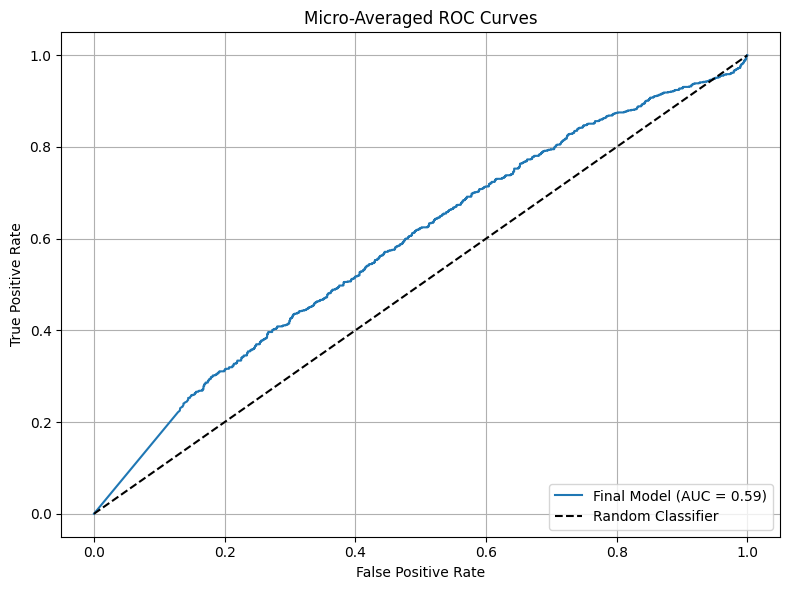

{'Final Model':               precision    recall  f1-score     support
 0              0.506369  0.417323  0.457554  381.000000
 1              0.379921  0.739464  0.501951  261.000000
 2              0.223684  0.066406  0.102410  256.000000
 accuracy       0.410913  0.410913  0.410913    0.410913
 macro avg      0.369992  0.407731  0.353971  898.000000
 weighted avg   0.389030  0.410913  0.369214  898.000000}

In [27]:
best = study.best_params

final_model = EEGConvNeXt_1D(
    n_channels=actual_n_channels,
    n_timesteps=actual_n_timesteps,
    num_classes=num_classes_actual,
    depths=[best["n_blocks"]]*2 + [best["n_blocks"]*2]*1 + [best["n_blocks"]],  # or however you want to map them
    dims=[best["base_dim"], best["base_dim"]*2, best["base_dim"]*4, best["base_dim"]*8],
    dropout_rate=best["dropout_rate"]
).to(device)

opt_final = optim.Adam(final_model.parameters(), lr=best["learning_rate"])
crit_final = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Train fully
train_model(final_model, train_loader, val_loader, crit_final, opt_final, num_epochs=50, device=device)

# Evaluate on test set as before...
evaluate_and_compare_models(final_model, "Final Model", test_loader, device, num_classes_actual)
